Accuracy(Multinomial Naive Bayes): 0.7631
Classification Report:
               precision    recall  f1-score   support

           0     0.9684    0.7658    0.8553      1200
           1     0.2280    0.7345    0.3480       113

    accuracy                         0.7631      1313
   macro avg     0.5982    0.7502    0.6016      1313
weighted avg     0.9047    0.7631    0.8116      1313



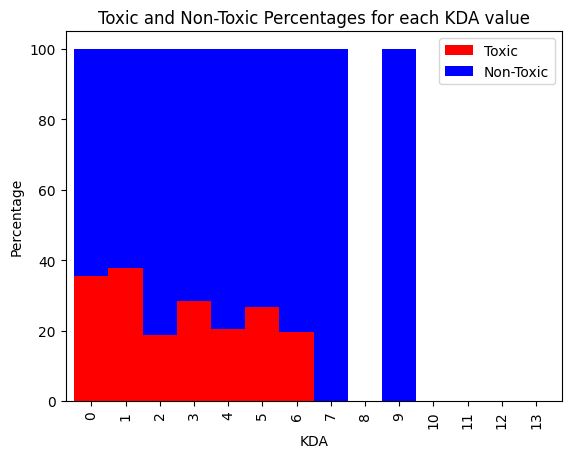

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np

# data loading
data = pd.read_csv('csv/output2.csv')

# split data
X = data[['message', 'kda']]
y = data['label']

# split data for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75)

# use TF-IDF for feature extraction
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['message'].astype(str) + ' ' + X_train['kda'].astype(str))
X_test_tfidf = tfidf_vectorizer.transform(X_test['message'].astype(str) + ' ' + X_test['kda'].astype(str))

# SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# train naive bayes with balanced data
nb_model = MultinomialNB()
nb_model.fit(X_train_smote, y_train_smote)

# predict binary labels
predicted_labels = nb_model.predict(X_test_tfidf)

# classification report
report = classification_report(y_test, predicted_labels, digits=4)
accuracy = accuracy_score(y_test, predicted_labels)
print(f'Accuracy(Multinomial Naive Bayes): {accuracy:.4f}')
print('Classification Report:\n', report)

message_id_finder = data.loc[X_test.index, 'message_id']

# create new df
new_df = pd.DataFrame({
    'message_id': message_id_finder,
    'kda': X_test['kda'],
    'predicted_label': predicted_labels
})

# Add a new column 'Toxic' based on the predicted labels
new_df['Toxic'] = new_df['predicted_label'].apply(lambda x: 'Toxic' if x == 1 else 'Non-Toxic')

# Bin the KDA values into ranges
bins = list(range(0, 15))  # Adjust this to fit your specific KDA ranges
new_df['kda_bins'] = pd.cut(new_df['kda'], bins=bins, include_lowest=True, right=False)

# Calculate the percentage of toxic and non-toxic predictions for each KDA bin
grouped = new_df.groupby(['kda_bins', 'Toxic']).size().unstack(fill_value=0)
percentage_df = grouped.div(grouped.sum(axis=1), axis=0) * 100  # Multiply by 100 to convert to percentage

# Create the stacked bar chart
ax = percentage_df[['Toxic', 'Non-Toxic']].plot(kind='bar', stacked=True, color=['red', 'blue'], width=1)

# Add labels and title
plt.xlabel('KDA')
plt.ylabel('Percentage')
plt.title('Toxic and Non-Toxic Percentages for each KDA value')
plt.legend()

# Adjust x-axis labels
ax.set_xticklabels(range(0, 14))

# Display the plot
plt.show()


Accuracy(Bidirectional Long Short-Term Memory [LSTM]): 0.9520
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1205
         1.0       0.78      0.57      0.66       108

    accuracy                           0.95      1313
   macro avg       0.87      0.78      0.82      1313
weighted avg       0.95      0.95      0.95      1313

Confusion Matrix:
 [[1188   17]
 [  46   62]]


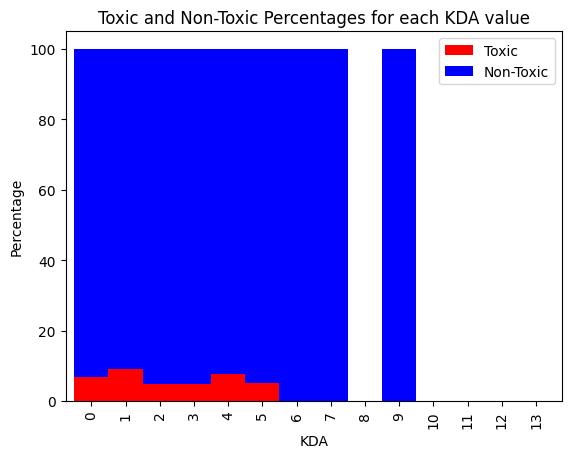

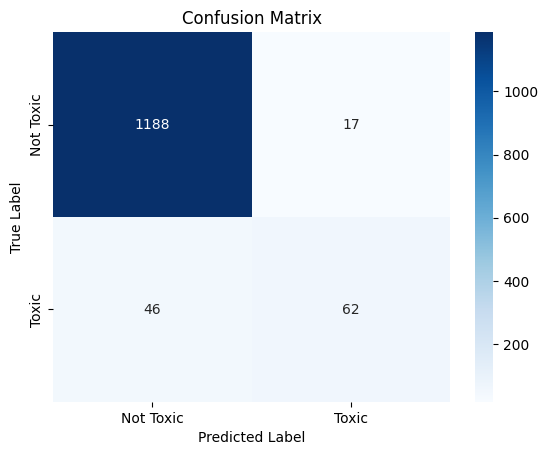

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# data reading and preprocessing
df = pd.read_csv('csv/output2.csv')

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# split gather data
X = df['message']
y = df['label']
message_ids = df['message_id']
kda_values = df['kda']

# countvectorizer to convert text into vectors
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X).toarray()

# convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)

# split data into training sets before SMOTE
X_train, X_test, y_train, y_test, ids_train, ids_test, kda_train, kda_test = train_test_split(
    X, y, message_ids, kda_values, test_size=0.75, random_state=42)

# SMOTE on the training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# convert resampled data to PyTorch tensors
X_train_resampled = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_resampled = torch.tensor(y_train_resampled, dtype=torch.float32)

# define Bidirectional LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        out = self.sigmoid(out)
        return out

# initialize model / loss function / optimizer
input_size = X_train_resampled.shape[1]
hidden_size = 128
num_layers = 2
output_size = 1

model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train model
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train_resampled), batch_size):
        inputs = X_train_resampled[i:i+batch_size]
        labels = y_train_resampled[i:i+batch_size]

        # forward pass
        outputs = model(inputs.unsqueeze(1)) 
        loss = criterion(outputs.squeeze(), labels)

        # backward optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# model eval
with torch.no_grad():
    model.eval()
    y_pred = model(X_test.unsqueeze(1))

y_pred = (y_pred > 0.5).float()
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy(Bidirectional Long Short-Term Memory [LSTM]): {accuracy:.4f}')
print('Classification Report:\n', report)
print('Confusion Matrix:\n', conf_matrix)

# Create a new DataFrame with messages, message id, kda, and labels generated by the model
new_df = pd.DataFrame({
    'message_id': ids_test,
    'message': X_test[:, 0].tolist(),
    'kda': kda_test.tolist(),
    'predicted_label': y_pred.flatten().tolist()
})

# Add a new column 'Toxic' based on the predicted labels
new_df['Toxic'] = new_df['predicted_label'].apply(lambda x: 'Toxic' if x == 1 else 'Non-Toxic')

# Bin the KDA values into ranges
bins = list(range(0, 15))  # Adjust this to fit your specific KDA ranges
new_df['kda_bins'] = pd.cut(new_df['kda'], bins=bins, include_lowest=True, right=False)

# Calculate the percentage of toxic and non-toxic predictions for each KDA bin
grouped = new_df.groupby(['kda_bins', 'Toxic']).size().unstack(fill_value=0)
percentage_df = grouped.div(grouped.sum(axis=1), axis=0) * 100  # Multiply by 100 to convert to percentage

# Create the stacked bar chart
ax = percentage_df[['Toxic', 'Non-Toxic']].plot(kind='bar', stacked=True, color=['red', 'blue'], width=1)

# Add labels and title
plt.xlabel('KDA')
plt.ylabel('Percentage')
plt.title('Toxic and Non-Toxic Percentages for each KDA value')
plt.legend()

# Adjust x-axis labels
ax.set_xticklabels(range(0, 14))

# Display the plot
plt.show()


# confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Toxic", "Toxic"], yticklabels=["Not Toxic", "Toxic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# # new test set
# X_original_test = X_test[:len(X_test) // 2]
# y_original_test = y_test[:len(y_test) // 2]

# # evaluation using new test set
# with torch.no_grad():
#     model.eval()
#     y_pred_original = model(X_original_test.unsqueeze(1))

# y_pred_original = (y_pred_original > 0.5).float()
# accuracy_original = accuracy_score(y_original_test, y_pred_original)
# report_original = classification_report(y_original_test, y_pred_original)
# conf_matrix_original = confusion_matrix(y_original_test, y_pred_original)

# print(f'Accuracy(Bidirectional Long Short-Term Memory [LSTM]) on Original Test Set: {accuracy_original:.4f}')
# print('Classification Report on Original Test Set:\n', report_original)
# print('Confusion Matrix on Original Test Set:\n', conf_matrix_original)

# # second confusion matrix
# sns.heatmap(conf_matrix_original, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Toxic", "Toxic"], yticklabels=["Not Toxic", "Toxic"])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix (Original Test Set)")
# plt.show()


Accuracy(SVM with Linear Kernel): 0.9513
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1194
           1       0.87      0.55      0.67       119

    accuracy                           0.95      1313
   macro avg       0.91      0.77      0.82      1313
weighted avg       0.95      0.95      0.95      1313



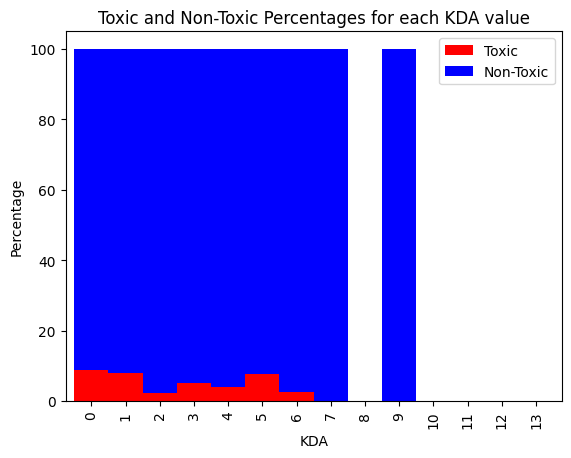

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np

# data loading and splitting
data = pd.read_csv('csv/output2.csv')

X = data[['message', 'kda']]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75)

# extract using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['message'].astype(str) + ' ' + X_train['kda'].astype(str))
X_test_tfidf = tfidf_vectorizer.transform(X_test['message'].astype(str) + ' ' + X_test['kda'].astype(str))

# SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# train SVM with linear kernel on the balanced data
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_smote, y_train_smote)

# binary labels
predicted_labels = svm_model.predict(X_test_tfidf)

# calculating accuracy separately
accuracy = accuracy_score(y_test, predicted_labels)

# make classification report
report = classification_report(y_test, predicted_labels, digits=2, output_dict=True)
report_str = classification_report(y_test, predicted_labels, digits=2)

print(f'Accuracy(SVM with Linear Kernel): {accuracy:.4f}')
print(f'Classification Report:\n{report_str}')

# Assuming that 'message_id' is a column in your original dataframe 'data'
message_id_test = data.loc[X_test.index, 'message_id']

# Create a new dataframe
new_df = pd.DataFrame({
    'message_id': message_id_test,
    'kda': X_test['kda'],
    'predicted_label': predicted_labels
})

# Add a new column 'Toxic' based on the predicted labels
new_df['Toxic'] = new_df['predicted_label'].apply(lambda x: 'Toxic' if x == 1 else 'Non-Toxic')

# Bin the KDA values into ranges
bins = list(range(0, 15))  # Adjust this to fit your specific KDA ranges
new_df['kda_bins'] = pd.cut(new_df['kda'], bins=bins, include_lowest=True, right=False)

# Calculate the percentage of toxic and non-toxic predictions for each KDA bin
grouped = new_df.groupby(['kda_bins', 'Toxic']).size().unstack(fill_value=0)
percentage_df = grouped.div(grouped.sum(axis=1), axis=0) * 100  # Multiply by 100 to convert to percentage

# Create the stacked bar chart
ax = percentage_df[['Toxic', 'Non-Toxic']].plot(kind='bar', stacked=True, color=['red', 'blue'], width=1)

# Add labels and title
plt.xlabel('KDA')
plt.ylabel('Percentage')
plt.title('Toxic and Non-Toxic Percentages for each KDA value')
plt.legend()

# Adjust x-axis labels
ax.set_xticklabels(range(0, 14))

# Display the plot
plt.show()

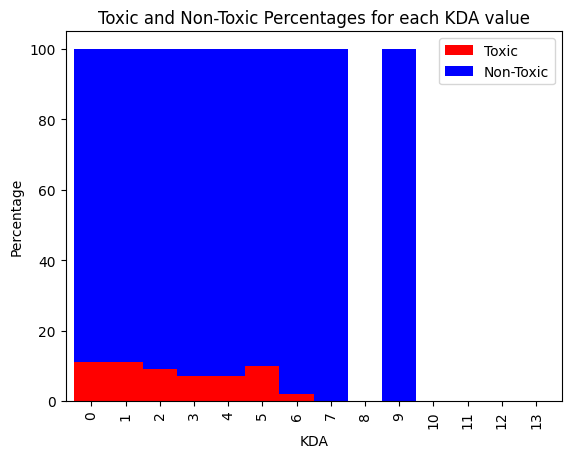

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the new DataFrame
df = pd.read_csv('csv/output2.csv')

# Add a new column 'Toxic' based on the labels
df['Toxic'] = df['label'].apply(lambda x: 'Toxic' if x == 1 else 'Non-Toxic')

# Bin the KDA values into ranges
bins = list(range(0, 15))  # Adjust this to fit your specific KDA ranges
df['kda_bins'] = pd.cut(df['kda'], bins=bins, include_lowest=True, right=False)

# Calculate the percentage of toxic and non-toxic predictions for each KDA bin
grouped = df.groupby(['kda_bins', 'Toxic']).size().unstack(fill_value=0)
percentage_df = grouped.div(grouped.sum(axis=1), axis=0) * 100  # Multiply by 100 to convert to percentage

# Create the stacked bar chart
ax = percentage_df[['Toxic', 'Non-Toxic']].plot(kind='bar', stacked=True, color=['red', 'blue'], width=1)

# Add labels and title
plt.xlabel('KDA')
plt.ylabel('Percentage')
plt.title('Toxic and Non-Toxic Percentages for each KDA value')
plt.legend()

# Adjust x-axis labels
ax.set_xticklabels(range(0, 14))

# Display the plot
plt.show()
